In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import SVHN
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape
from inpainting.losses import nll_masked_batch_loss, nll_masked_batch_loss_components, loss_with_mixup, nll_masked_batch_loss_same_size_masks
from pathlib import Path
import inpainting.visualizations.samples as vis
from inpainting.visualizations.digits import rgb_with_mask
import pickle

In [4]:
from inpainting.datasets.celeba import train_val_datasets as celeba_train_val_ds, DEFAULT_MASK_CONFIGS
from inpainting.datasets.svhn import train_val_datasets as svhn_train_val_ds
from inpainting.datasets.mask_coding import UNKNOWN_LOSS
from inpainting.datasets.utils import RandomRectangleMaskConfig
from inpainting.visualizations.digits import rgb_with_mask 
from inpainting.training import train_inpainter
from inpainting.utils import classifier_experiment, inpainted, predictions_for_entire_loader
from inpainting.inpainters.rgb import RGBInpainter
from inpainting.inpainters.fullconv import FullyConvolutionalInpainter
from inpainting import backbones as bkb
from inpainting import losses2 as l2

In [5]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = "white"

In [6]:
# !ps aux | grep mprzewie 

In [7]:
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi

1
Sun May  3 21:38:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 29%   28C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 50%   79C    P2   232W / 250W |  10869MiB / 12196MiB |     88%      Default |
+-------------------------------+----------------------+----------------------+
|   2 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

In [9]:
experiment_path = Path("../results/celeba/fullconv/64x64_64_3_64_no_latent")
experiment_path.mkdir(exist_ok=True, parents=True)

Files already downloaded and verified
Files already downloaded and verified


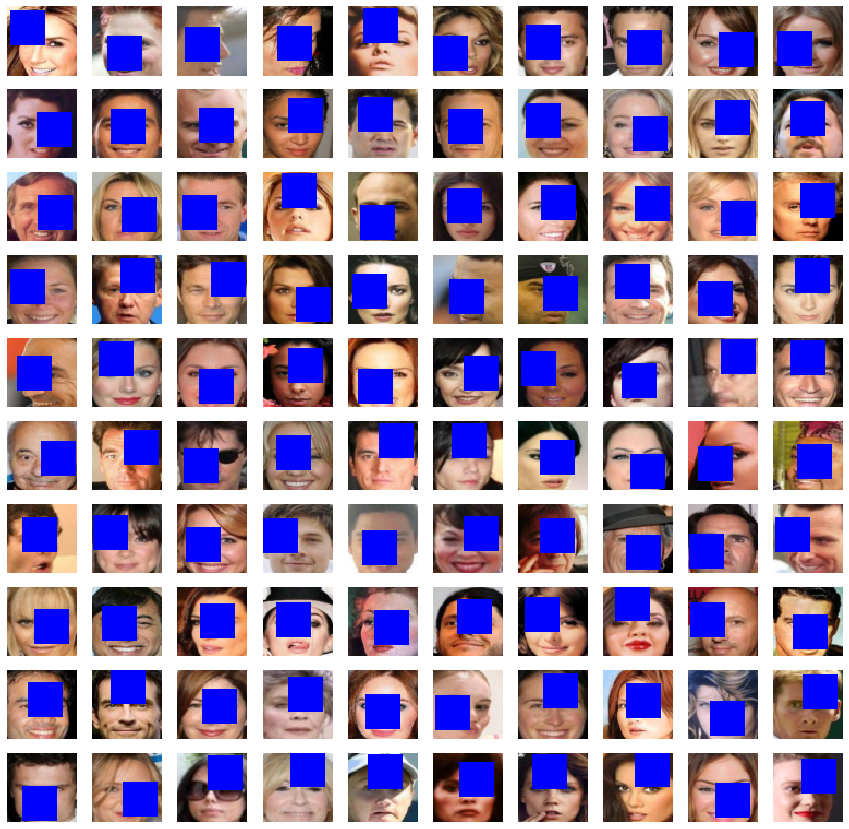

(162770, 19867)

In [10]:
ds_train, ds_val = celeba_train_val_ds(
    Path.home() / "uj/.data/", 
    mask_configs=[RandomRectangleMaskConfig(UNKNOWN_LOSS,32, 32)],
    resize_size=(120, 120),
    crop_size=(64, 64),
    deterministic=False
)

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    (x,j), y = ds_train[i]
#     print(x.shape)
    ax = axes[i // 10, i%10]
#     ax.set_title(f"{y}")
    rgb_with_mask(x.numpy(), j.numpy(), ax)
train_fig = plt.gcf()
train_fig.savefig(experiment_path / "train.png")
plt.show()

len(ds_train), len(ds_val)

In [11]:
batch_size=24
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

In [12]:
log_noms = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_noms"]

x_minus_means = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["x_minus_means"]

x_minus_means_2 = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["x_minus_means_2"]

log_dets = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_dets"]

log_2_pi = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_2_pi"]

a_var = lambda x,j,p,m,a,d: a.var()

64x64 - 2416090845

32x32 - 151092957

In [13]:
!nvidia-smi

Sun May  3 21:38:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 29%   28C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 50%   79C    P2   229W / 250W |  10869MiB / 12196MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [14]:
history = []

inpainter = FullyConvolutionalInpainter(
    n_mixes=1, a_width=4, a_amplitude=1, c_h_w=(3, 64, 64), last_channels=64, 
    extractor=bkb.down_up_backbone(
        (6, 64, 64),
        depth=3,
        first_channels=64, 
        last_channels=64,
        kernel_size=5,
        latent=False
    )
)
# inpainter.to(device)
opt = optim.Adam(inpainter.parameters(), lr=4e-5, weight_decay=0)


In [15]:
ckp_path = experiment_path / "inpainter.state"
if ckp_path.exists():
    print("resuming model")
    chckp = torch.load(ckp_path)
    inpainter.load_state_dict(chckp())

In [ ]:
inpainter.train()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_epochs = 20

history = train_inpainter(
    inpainter, 
    dl_train, 
    dl_val, 
    opt, 
    loss_fn =l2.nll_buffered, 
    n_epochs=n_epochs,
    device=device,
    max_benchmark_batches=200,
    
    losses_to_log=dict(
        mse=l2.loss_factory(
            gathering_fn=l2.buffered_gather_batch_by_mask_indices,
            calc_fn=l2.mse
        )
    ),
    tqdm_loader=True
)

{'all params': 4049331, 'backbone params': 3711296}


  0%|          | 0/828 [00:00<?, ?it/s]/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
 24%|██▍       | 201/828 [01:12<01:49,  5.72it/s]

 54%|█████▎    | 3635/6783 [26:16<22:46,  2.30it/s]  

In [ ]:
len(history)

In [ ]:
# with (experiment_path / "history_last_epoch.pkl").open("rb") as f:
#     history = [pickle.load(f)]

In [ ]:

with (experiment_path / "history_last_epoch.pkl").open("wb") as f:
    history_tmp = history
    pickle.dump(history[-1], f)

In [ ]:
with (experiment_path / "inpainter.schema").open("w") as f:
    print(inpainter, file=f)
with (experiment_path / "opt.schema").open("w") as f:
    print(opt, file=f)

# torch.save(inpainter.state_dict, experiment_path / "inpainter.state")

In [ ]:
[h["losses"] for h in history];

In [ ]:
history[-1]["losses"]["objective"]

In [ ]:
history_tmp = history
history = history

In [ ]:
for loss_name in set(history[0]["losses"].keys()):
    for fold in ["train", "val"]:
        
        plt.plot(
            list(range(len(history))),
            [h["losses"][loss_name][fold] for h in history],
            label=fold
        )
    plt.title(loss_name)
    plt.legend()
    fig = plt.gcf()
    fig.savefig(experiment_path / f"history.{loss_name}.png")
    plt.show()

In [ ]:
skip = 10

row_length = vis.row_length(*list(zip(*history[0]["sample_results"]["train"]))[0])
fig, axes = plt.subplots(
    int(np.ceil(len(history) / skip)* 2), 
    row_length,
    figsize=(20, 30)
)


for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        x, j, p, m, a, d, y = [t[0] for t in  h["sample_results"][fold]]
        row_no = (e // skip)*2 + ax_no

        vis.visualize_sample(
            x, j, p, m, a, d, y, 
            ax_row=axes[row_no], 
            title_prefixes={
                0: f"{e} {fold} ",
#                 1: f"y_m = {y_masked_pred}"
            },
            drawing_fn=rgb_with_mask
        )

epochs_fig = plt.gcf()
epochs_fig.savefig(experiment_path / "epochs_renders.png")

In [ ]:
epochs_path = experiment_path / "epochs"
epochs_path.mkdir(exist_ok=True)
skip = 10
n_rows = 16

for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        
        
        row_length = vis.row_length(*list(zip(*h["sample_results"][fold]))[0])

        fig, axes = plt.subplots(
            n_rows, 
            row_length,
            figsize=(20, 30)
        )

        for row_no, (x, j, p, m ,a, d, y) in enumerate(list(zip(*h["sample_results"][fold]))[:n_rows]):
            vis.visualize_sample(
                x, j, p, m, a, d, y, 
                ax_row=axes[row_no], 
                title_prefixes={
                    0: f"{e} {fold} ",
#                     1: f"y_m = {y_masked_pred}"
                },
                drawing_fn=rgb_with_mask
            )
        
        title = f"{e}_{fold}"
        plt.suptitle(title)
        plt.savefig(epochs_path / f"{title}.png")
#         plt.show()
            

# epochs_fig = plt.gcf()
# epochs_fig.savefig(experiment_path / "epochs_renders.png")

In [ ]:
import matplotlib.pyplot as plt

def plot_arrays_stats(
    arrays, ax=None, stat_fns = [np.min, np.max, np.mean], markers="."
):
    if ax is None:
        fig, ax = plt.subplots()
        
    if isinstance(markers, str):
        markers = [markers] * len(stat_fns)
    
    for fn, m in zip(stat_fns, markers):
        ax.scatter(
            range(len(arrays)),
            [
                fn(a) for a in arrays
            ],
            marker=m,
            label=fn.__name__
            
        )
    
    return ax

In [ ]:
hist_last_epoch = history[-1]

In [ ]:
for fold in ["val"]:
    x, j, p, m, a, d, y = hist_last_epoch["sample_results"][fold]

    a_resh = a.reshape(a.shape[0] * a.shape[1], a.shape[2], a.shape[3])
    covs = a_resh.transpose(0, 2, 1) @ a_resh
    
    fig, ax = plt.subplots(figsize=(20, 25), nrows=5)
    
    ax[0].set_title(f"m stats {fold}")
    plot_arrays_stats(
        m, ax[0]
    )
        
    samples = [
        vis.gans_gmms_sample_no_d(x_, m_[0], a_[0], d_[0])
        for (x_, m_, a_, d_) in zip(x, m ,a, d)
    ]
    
    ax[1].set_title("samples stats")
    plot_arrays_stats(samples, ax[1])
    
    ax[2].set_title(f"a stats {fold}")
    plot_arrays_stats(
        a, ax[2]
    )
    
    ax[3].set_title(f"d stats {fold}")
    plot_arrays_stats(
        d, ax[3]
    )
    
    ax[4].set_title(f"cov stats {fold}")
    plot_arrays_stats(
        covs, ax[4]
    )
    [a.legend() for a in ax[:5]]
    fig.savefig(experiment_path / f"outputs_stats.png")
    plt.show()
    
    cov_resh = covs[0].reshape(-1)
    plt.hist(cov_resh, log=True, bins=100)
    plt.title(f"cov[0] hist {fold}")
    plt.show()
    
    cov = covs[0]
    
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
    eigs = np.linalg.eigvals(cov)
    ax[0].scatter(range(len(eigs)), eigs)
    ax[0].set_title("eigenvals of cov[0]")

    cov_d = cov + np.diag(d[0])
    eigs_d = np.linalg.eigvals(cov_d)
    ax[1].scatter(range(len(eigs_d)), eigs_d)
    ax[1].set_title("eigenvals of cov[0] + d[0]")
    fig.savefig(experiment_path / "eigenvals.png")
    plt.show()

    # wygląda na to, że mamy ~3 duże wartosci własne
    
    print("m analysis")
    
    
    plt.hist(d[0].reshape(-1), bins=100, log=True)
    plt.title("d[0] hist")
    plt.show()
    
#     for i in range(3):
#         plt.imshow(a_resh[0, i].reshape(28,28), cmap="gray")
#         plt.show()
    
    
    
    

In [ ]:
val_results = predictions_for_entire_loader(
    inpainter.to(torch.device("cpu")),
    dl_val,
    torch.device("cpu")
    
)
with (experiment_path / "val_predictions.pkl").open("wb") as f:
    pickle.dump(val_results, f)
    

In [ ]:
fig, ax = plt.subplots(10, 11, figsize=(15,15)
)

for i in range(10):
    vis.visualize_sample(
        *val_results[i],
        drawing_fn=rgb_with_mask,
        title_prefixes=dict(),
        ax_row=ax[i]
    )